<img src="./img/Logo.png" align="right" width="50%"></img>
# MissionAtlantic GeoNode Workshop
## How to use OGC webservices offered by the MissionAtlantic GeoNode in your data analysis

### 3. Subset & download data using OGC Web Feature and Coverage Services (WFS/WCS)

The OWSLib library is a python library that makes accessing data and metadata through OGC services possible. The library abstracts all of the traditional HTTP API calls into programmatic function calls. We will be using this library throughout the tutorial to interact with the MissionAtlantic GeoNode OGC services.

The library is available from GitHub @  https://github.com/geopython/OWSLib

In [51]:
from owslib.wfs import WebFeatureService
from owslib.wcs import WebCoverageService
from matplotlib import pyplot as plt

### 3.1 Get vector data with WFS

#### Create a WebFeatureService (WFS) object
Note that we use version 1.1.0 as in OWSLib this version has support for [OGC Filter Encoding](https://www.ogc.org/standards/filter)

In [52]:
wfs = WebFeatureService('https://geonode.missionatlantic.eu/geoserver/ows', version = '1.1.0')

#### Find out what the WFS has to offer. Service metadata:

In [53]:
print(wfs.identification.type)
print(wfs.identification.version)
print(wfs.identification.title)
print(wfs.identification.abstract)

WFS
1.1.0
Mission Atlantic GeoNode WFS service
This is the WFS service of the Mission Atlantic GeoNode


#### See available methods

In [54]:
[operation.name for operation in wfs.operations]

['GetCapabilities',
 'DescribeFeatureType',
 'GetFeature',
 'GetGmlObject',
 'LockFeature',
 'GetFeatureWithLock',
 'Transaction']

#### Get available formats

In [55]:
wfs.getOperationByName('GetFeature').parameters

{'resultType': {'values': ['results', 'hits']},
 'outputFormat': {'values': ['text/xml; subtype=gml/3.1.1',
   'GML2',
   'KML',
   'SHAPE-ZIP',
   'application/gml+xml; version=3.2',
   'application/json',
   'application/vnd.google-earth.kml xml',
   'application/vnd.google-earth.kml+xml',
   'application/x-gpkg',
   'csv',
   'excel',
   'excel2007',
   'geopackage',
   'geopkg',
   'gml3',
   'gml32',
   'gpkg',
   'json',
   'text/csv',
   'text/javascript',
   'text/xml; subtype=gml/2.1.2',
   'text/xml; subtype=gml/3.2']}}

#### Find out what vector datasets (FeatureTypes) are available
Note that only vector datasets that are uploaded to the GeoNode and are publicly available are shown

In [56]:
list(wfs.contents)

['geonode:Wind_Farms_EMODnet']

In [57]:
# Select the desired dataset among the list returned above
dataset = 'geonode:Wind_Farms_EMODnet'

#### Get the FeatureType Metadata an Bounding Box:

In [58]:
print(wfs.contents[dataset].title)
print(wfs.contents[dataset].abstract)
bbox1 = wfs.contents[dataset].boundingBoxWGS84
print (bbox1)

EMODnet, Human Activities, Energy, Wind Farms
The database on offshore wind farms in the EU was created in 2014 by CETMAR for the European Marine Observation and Data Network (EMODnet). It is the result of the aggregation and harmonization of datasets provided by several sources. It is updated every year and is available for viewing and download on EMODnet Human Activities web portal (https://emodnet.ec.europa.eu/en/human-activities). The database contains points and/or (where available) polygons representing offshore wind farms in the following countries: Belgium, Denmark, Estonia, Finland, France, Germany, Greece, Ireland, Italy, Latvia, Lithuania, Netherlands, Norway, Poland, Portugal, Spain, Sweden and United Kingdom. Each point has the following attributes (where available): Name, Nº of turbines, Status (Approved, Planned, Dismantled, Construction, Production, Test site), Country, Year, Power (MW), Distance to coast (metres) and Area (square kilometres). The distance to coast (EEA

#### Get the FeatureType’s schema via `DescribeFeatureType`.
The dictionary returned is compatible with a [Fiona schema object](https://fiona.readthedocs.io/en/latest/fiona.html#fiona.collection.Collection.schema).

In [59]:
wfs.get_schema(dataset)

{'properties': {'fid': 'int',
  'country': 'string',
  'n_turbines': 'long',
  'power_mw': 'double',
  'status': 'string',
  'year': 'string',
  'dist_coast': 'double',
  'area_sqkm': 'double',
  'notes': 'string'},
 'required': ['fid'],
 'geometry': '3D MultiPolygon',
 'geometry_column': 'the_geom'}

#### Subset data with a bounding box

In [60]:
# Subset data with a bounding box
response = wfs.getfeature(typename=dataset,
                          bbox=(bbox1), #subset to the Study area ( based on bbox params)
                          outputFormat='application/json')

# Write it to a GeoJson file
with open(f'data/{dataset.replace(":","_")}.json', 'wb') as outfile:
    outfile.write(response.read())
response.close()

# Read the GeoJson file using GeoPandas
import geopandas as gpd
gdf = gpd.read_file(f'data/{dataset.replace(":","_")}.json')
gdf

,id,fid,country,n_turbines,power_mw,status,year,dist_coast,area_sqkm,notes,geometry
0,Wind_Farms_EMODnet.1,1,Sweden,108.0,864.0,Planned,,24805.731113,59.826131,,"MULTIPOLYGON (((12.03532 56.65295, 12.06134 56..."
1,Wind_Farms_EMODnet.2,2,Sweden,5.0,11.5,Production,,0.000000,0.193854,,"MULTIPOLYGON (((12.46710 56.89015, 12.47244 56..."
2,Wind_Farms_EMODnet.3,3,Sweden,50.0,282.0,Approved,,6381.649369,22.111037,,"MULTIPOLYGON (((12.33361 56.86036, 12.34738 56..."
3,Wind_Farms_EMODnet.4,4,United Kingdom,10.0,10.0,Planned,,45.484159,4.756627,,"MULTIPOLYGON (((-6.48391 58.43840, -6.45466 58..."
4,Wind_Farms_EMODnet.5,5,United Kingdom,10.0,10.0,Approved,,1122.942248,27.611537,,"MULTIPOLYGON (((-6.52572 55.65146, -6.55948 55..."
...,...,...,...,...,...,...,...,...,...,...,...
526,Wind_Farms_EMODnet.527,527,Spain,NaN,NaN,Planned,,6352.036015,164.014429,,"MULTIPOLYGON (((-15.22104 27.87453, -15.22323 ..."
527,Wind_Farms_EMODnet.528,528,Estonia,NaN,NaN,Planned,,10936.264024,475.437637,,"MULTIPOLYGON (((22.87573 57.88582, 22.83318 57..."
528,Wind_Farms_EMODnet.529,529,Estonia,NaN,NaN,Planned,,9903.634178,1217.896092,,"MULTIPOLYGON (((21.69848 57.84691, 21.65391 57..."
529,Wind_Farms_EMODnet.530,530,Estonia,NaN,NaN,Planned,,53078.632060,87.964217,,"MULTIPOLYGON (((20.79879 58.23678, 20.89771 58..."


C:\Users\matteo.mikos\AppData\Local\Temp\ipykernel_25740\2282531803.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
c:\Users\matteo.mikos\AppData\Local\anaconda3\envs\ogc_workshop\Lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


(33.0, 65.0)

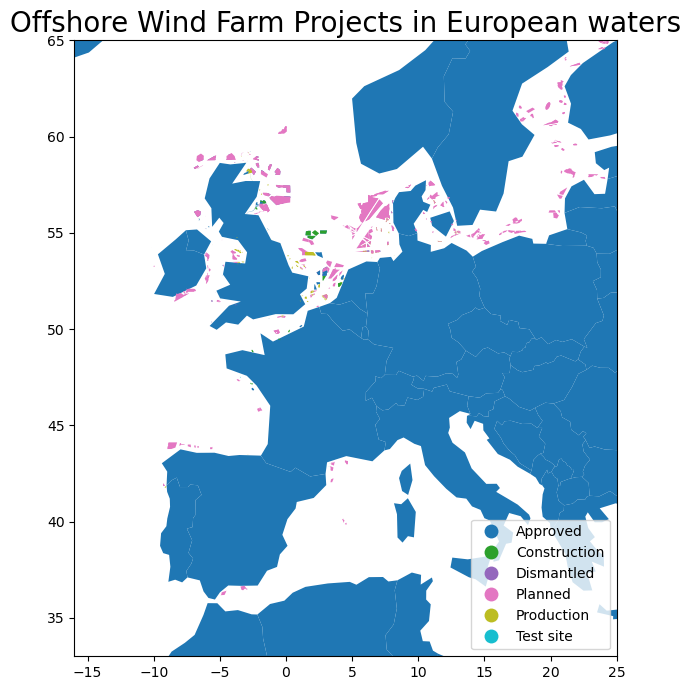

In [61]:
# Get shapefile of world outline
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(1, figsize=(9,8))
world.plot(ax=ax) # add world as base layer
gdf.plot(column='status',
         categorical=False,
         cmap='tab10',
         legend= True,
         legend_kwds={'loc': 'lower right'},
         alpha = 1,
         ax=ax) # Add study areas colored by study region number
ax.set_title('Offshore Wind Farm Projects in European waters',fontsize=20)

#Set the map limits based on the bbox params to zoom in on your dataset
ax.set_xlim(-16,25) 
ax.set_ylim(33,65)

#### Subset data by attributes using [OGC Filter Encoding](https://www.ogc.org/standards/filter)

In [62]:
#Import the Filter encoding standard
import owslib.fes as fes 
from owslib.etree import etree

# Build a filter
sa_filter = fes.PropertyIsEqualTo(propertyname='status', literal='Planned') # Planned Windfarm projects
fid_filter = fes.PropertyIsBetween(propertyname='area_sqkm', lower = 1000, upper= 100000) # filter for projects bigger than 1000Km²
filter = fes.And([sa_filter,fid_filter]) # combine both filtering parameters using "AND"

# Get an xml representation of the filter
filterxml = etree.tostring(filter.toXML()).decode("utf-8")

# Pass it to getFeature
response = wfs.getfeature(typename=dataset,
                        outputFormat='application/json',
                        filter=filterxml)

# Write it to a GeoJson file
with open(f'data/{dataset.replace(":","_")}_filtered.json', 'wb') as outfile:
    outfile.write(response.read())
response.close()

# Read the GeoJson file using GeoPandas
gdf = gpd.read_file(f'data/{dataset.replace(":","_")}_filtered.json')
gdf

,id,fid,country,n_turbines,power_mw,status,year,dist_coast,area_sqkm,notes,geometry
0,Wind_Farms_EMODnet.40,40,Denmark,NaN,NaN,Planned,,49194.172947,1872.941410,,"MULTIPOLYGON (((6.41926 55.80585, 6.41538 55.8..."
1,Wind_Farms_EMODnet.48,48,Denmark,NaN,NaN,Planned,,19964.419331,3176.148975,,"MULTIPOLYGON (((7.79172 56.37805, 7.79165 56.3..."
2,Wind_Farms_EMODnet.36,36,Denmark,NaN,NaN,Planned,,109379.688310,4484.323143,,"MULTIPOLYGON (((6.33084 56.44456, 6.32952 56.4..."
3,Wind_Farms_EMODnet.44,44,Denmark,NaN,NaN,Planned,,73863.316263,1642.587692,,"MULTIPOLYGON (((6.51131 56.88091, 6.54150 56.8..."
4,Wind_Farms_EMODnet.81,81,Netherlands,NaN,4000.0,Planned,,49466.898142,1172.060155,,"MULTIPOLYGON (((3.74863 53.16913, 3.74864 53.0..."
5,Wind_Farms_EMODnet.133,133,Ireland,NaN,NaN,Planned,,0.000000,1009.408557,,"MULTIPOLYGON (((-7.49680 52.06100, -7.49660 52..."
6,Wind_Farms_EMODnet.294,294,United Kingdom,NaN,NaN,Planned,2020,9457.333545,1106.354044,,"MULTIPOLYGON (((-6.32441 59.05853, -6.31226 59..."
7,Wind_Farms_EMODnet.295,295,United Kingdom,NaN,NaN,Planned,2020,3171.943570,1162.427300,,"MULTIPOLYGON (((-4.10739 59.13575, -4.09759 59..."
8,Wind_Farms_EMODnet.297,297,United Kingdom,NaN,NaN,Planned,2020,59706.165817,1291.429348,,"MULTIPOLYGON (((-0.50129 57.47805, -0.48542 57..."
9,Wind_Farms_EMODnet.298,298,United Kingdom,NaN,NaN,Planned,2020,56455.635331,3743.866036,,"MULTIPOLYGON (((-0.47392 56.91518, -0.45823 56..."


c:\Users\matteo.mikos\AppData\Local\anaconda3\envs\ogc_workshop\Lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


(33.0, 65.0)

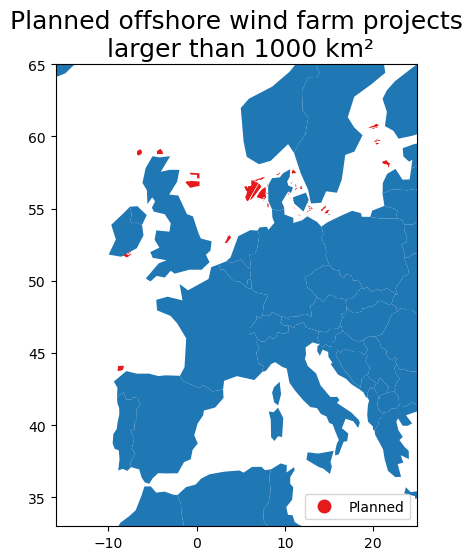

In [65]:
fig, ax = plt.subplots(1, figsize=(8,6))
world.plot(ax=ax) # add world base layer

#Plot the dataset
gdf.plot(column='status',
         categorical = False,
         cmap='Set1',
         legend= True,
         legend_kwds={'loc': 'lower right'},
         alpha = 1,
         ax=ax)
ax.set_title('Planned offshore wind farm projects\n larger than 1000 km²',fontsize=18)

#Set the map limits based on the bbox params to zoom in on your dataset
ax.set_xlim(-16,25)
ax.set_ylim(33,65)

## Example 2: Combining Subset of WFS request with a WCS (Web Coverage Services) request
### 1. Define a new study area

In this example, we will be looking to subset the "Non-Hierarchical habitat classification in the Atlantic Ocean in 2016" dataset obtained from the Mission Atlantic Geonode, to the marine region of the Greater North Sea (as defined by ICES Ecoregions).

#### 1.1 Connect to the MarineRegions.org WebFeatureService 
Marine Regions is an integration of the VLIMAR Gazetteer and the VLIZ Maritime Boundaries Geodatabase. The VLIMAR Gazetteer is a database with geographic, mainly marine names such as seas, sandbanks, seamounts, ridges, bays or even standard sampling stations used in marine research. It is accessible at: https://www.marineregions.org/gazetteer.php?p=search

In [14]:
wfs2 = WebFeatureService('https://geo.vliz.be/geoserver/MarineRegions/wfs', version= '1.1.0')

#Inspect available datasets
print(wfs2.identification.type)
print(wfs2.identification.version)
print(wfs2.identification.title)
print(wfs2.identification.abstract)
list(wfs2.contents)

WFS
1.1.0
Flanders Marine Institute (VLIZ) - WFS Service
This is the reference implementation of OGC WFS 1.0.0 and WFS 1.1.0, supports all WFS operations including Transaction.


['MarineRegions:eez_archipelagic_waters',
 'MarineRegions:arcticmarineareas',
 'MarineRegions:brasdorlakebiospherereserve',
 'MarineRegions:isa_ccz_managementarea',
 'MarineRegions:coasts_subnational',
 'MarineRegions:coasts_per_ocean',
 'MarineRegions:eez_24nm',
 'MarineRegions:comarge',
 'MarineRegions:cross_dateline_polygons',
 'MarineRegions:eca_reg13_nox',
 'MarineRegions:eca_reg14_sox_pm',
 'MarineRegions:eez',
 'MarineRegions:ecs',
 'MarineRegions:ecs_boundaries',
 'MarineRegions:fadaregions',
 'MarineRegions:fao',
 'MarineRegions:tnc_wwf_feow_hydrosheds',
 'MarineRegions:gsas_mediterraneanfishingzones',
 'MarineRegions:longhurst',
 'MarineRegions:goas',
 'MarineRegions:haedatgrids_polygon',
 'MarineRegions:high_seas',
 'MarineRegions:ices_ecoregions',
 'MarineRegions:ices_areas',
 'MarineRegions:ices_statistical_rectangles',
 'MarineRegions:iho',
 'MarineRegions:iho_quadrants_20150810',
 'MarineRegions:eez_internal_waters',
 'MarineRegions:itmarbiogeogsector_bianchi',
 'MarineR

In [15]:
#Define desired regional classification, here ICES Ecoregions
dataset2 = 'MarineRegions:ices_ecoregions'

# See available methods
[operation.name for operation in wfs2.operations]



['GetCapabilities',
 'DescribeFeatureType',
 'GetFeature',
 'GetGmlObject',
 'LockFeature',
 'GetFeatureWithLock',
 'Transaction']

In [16]:
#Inspect ICES Ecoregions dataset
print(wfs2.contents[dataset2].title)
print(wfs2.contents[dataset2].abstract)
bbox = wfs2.contents[dataset2].boundingBoxWGS84
print (bbox)

ICES Ecoregions (2015)
Delineation of the ICES Ecoregions was originally described in ICES Advice ACFM/ACE report(2004).

In the present updated version, the delineation has been updated to account for additional policy objectives and reconciling of legislation (eg the MSFD and the EU water and habitats directives)

The differences are based on the four principles:
1. Within the EU accept the MSFD regional and sub-regional definitions.
2. Separate Icelandic Seas from those around Greenland.
3. Use Large Marine Ecosystem units to define the Arctic Ocean.
4. Use the accepted Norwegian regional management plans definitions of the Norwegian and Barents Seas.

The Ecoregions were proposed to assist the implementation of the ecosystem approach in European waters
(-44.0000000000998, 30.2670495513959, 68.5000001347984, 90.0000000001001)


In [17]:
# Get the FeatureType’s schema via `DescribeFeatureType`
wfs2.get_schema(dataset2)

{'properties': {'objectid': 'int',
  'ecoregion': 'string',
  'mrgid': 'int',
  'longitude': 'decimal',
  'latitude': 'decimal',
  'area_km2': 'decimal',
  'placetype': 'string',
  'placetypei': 'int',
  'parent': 'string',
  'parentid': 'int',
  'source': 'string',
  'sourceid': 'int',
  'lon_min': 'decimal',
  'lon_max': 'decimal',
  'lat_min': 'decimal',
  'lat_max': 'decimal'},
 'required': [],
 'geometry': '3D MultiPolygon',
 'geometry_column': 'the_geom'}

#### 1.2 Inspect the ICES Ecoregions datasets
Listing all available regional delimitations based on the ICES Ecoregions classification

In [18]:
response = wfs2.getfeature(typename=dataset2,
                          bbox=(bbox), 
                          outputFormat='application/json')

# Write it to a GeoJson file
with open(f'data/{dataset2.replace(":","_")}.json', 'wb') as outfile:
    outfile.write(response.read())
response.close()

# Read the GeoJson file using GeoPandas
import geopandas as gpd
gdf = gpd.read_file(f'data/{dataset2.replace(":","_")}.json')
gdf

,id,objectid,ecoregion,mrgid,longitude,latitude,area_km2,placetype,placetypei,parent,parentid,source,sourceid,lon_min,lon_max,lat_min,lat_max,geometry
0,ices_ecoregions.1,1,Greenland Sea,36310,-28.070627,69.670326,1.065385e+06,ICES Ecoregion,246,ICES Ecoregions,22540,ICES,378,-44.000000,5.677908,56.560460,82.304253,"MULTIPOLYGON (((-43.99177 60.29694, -44.00000 ..."
1,ices_ecoregions.2,2,Bay of Biscay and the Iberian Coast,36311,-8.886815,42.662908,7.557796e+05,ICES Ecoregion,246,ICES Ecoregions,22540,ICES,378,-13.861560,-0.146245,36.000000,48.000002,"MULTIPOLYGON (((-5.60000 36.01104, -5.60000 36..."
2,ices_ecoregions.3,3,Azores,36312,-28.438624,39.154203,7.928794e+05,ICES Ecoregion,246,ICES Ecoregions,22540,ICES,378,-35.579300,-20.855320,36.000000,43.067630,"MULTIPOLYGON (((-21.05878 36.00000, -23.49448 ..."
3,ices_ecoregions.4,4,Western Mediterranean Sea,22167,6.109270,39.531134,8.444074e+05,ICES Ecoregion,246,ICES Ecoregions,22540,ICES,378,-5.600000,16.223122,35.070668,44.427203,"MULTIPOLYGON (((2.99963 43.14220, 2.99973 43.1..."
4,ices_ecoregions.5,5,Ionian Sea and the Central Mediterranean Sea,36313,17.320194,35.190387,7.726428e+05,ICES Ecoregion,246,ICES Ecoregions,22540,ICES,378,10.015849,24.122811,30.267050,40.520659,"MULTIPOLYGON (((24.12281 34.80180, 24.12272 34..."
5,ices_ecoregions.6,6,Black Sea,22172,34.262870,43.464598,4.747685e+05,ICES Ecoregion,246,ICES Ecoregions,22540,ICES,378,26.175552,42.354960,39.998909,47.376395,"MULTIPOLYGON (((41.58356 42.40528, 41.57035 42..."
6,ices_ecoregions.7,7,Adriatic Sea,36314,16.118553,42.714787,1.392988e+05,ICES Ecoregion,246,ICES Ecoregions,22540,ICES,378,12.065226,20.020828,39.744192,45.808914,"MULTIPOLYGON (((19.99367 39.79384, 19.99293 39..."
7,ices_ecoregions.8,8,Aegean-Levantine Sea,22169,28.686066,34.822184,7.567145e+05,ICES Ecoregion,246,ICES Ecoregions,22540,ICES,378,22.149885,36.215729,30.756594,41.091326,"MULTIPOLYGON (((25.74529 36.79303, 25.74350 36..."
8,ices_ecoregions.9,9,Celtic Seas,22173,-9.264609,54.591504,9.177512e+05,ICES Ecoregion,246,ICES Ecoregions,22540,ICES,378,-16.090850,1.806284,48.000002,63.890844,"MULTIPOLYGON (((1.37123 62.00000, 1.37123 62.0..."
9,ices_ecoregions.10,10,Baltic Sea,22170,19.497017,58.713587,3.999565e+05,ICES Ecoregion,246,ICES Ecoregions,22540,ICES,378,9.419914,31.685704,52.871122,67.080588,"MULTIPOLYGON (((11.07890 53.14186, 11.09182 53..."


#### 1.3 Write a filter to select the desired region (Greater North Sea)

,id,objectid,ecoregion,mrgid,longitude,latitude,area_km2,placetype,placetypei,parent,parentid,source,sourceid,lon_min,lon_max,lat_min,lat_max,geometry
0,ices_ecoregions.11,11,Greater North Sea,36317,2.932991,56.0119,670833.140245,ICES Ecoregion,246,ICES Ecoregions,22540,ICES,378,-5.0,13.062911,48.000002,62.000003,"MULTIPOLYGON (((-4.56139 48.00000, -4.56354 48..."


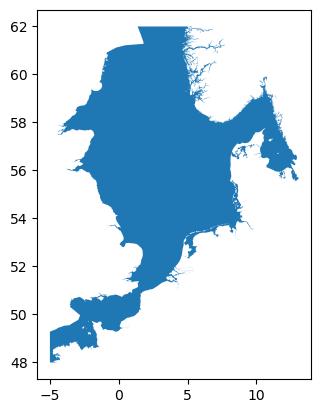

In [19]:
#Import the Filter encoding standard
import owslib.fes as fes 
from owslib.etree import etree

# Build a filter
filter = fes.PropertyIsEqualTo(propertyname='ecoregion', literal='Greater North Sea') # Specifying the needed Ecoregion

# Get an xml representation of the filter
filterxml = etree.tostring(filter.toXML()).decode("utf-8")

# Pass it to getFeature
response = wfs2.getfeature(typename = dataset2,
                        outputFormat='application/json',
                        filter=filterxml)

# Write it to a GeoJson file
with open(f'data/{dataset2.replace(":","_")}_filtered.json', 'wb') as outfile:
    outfile.write(response.read())
response.close()

# Read the GeoJson file using GeoPandas
Study_area = gpd.read_file(f'data/{dataset2.replace(":","_")}_filtered.json')

# Plot and inspect the study area dataset
Study_area.plot()
Study_area



### 3.2 Get raster data with WCS

#### <i>Create a WebCoverageService (WCS) object</i>

In [20]:
wcs = WebCoverageService('https://geonode.missionatlantic.eu/geoserver/ows', version = '1.0.0')

#### <i>Get a list of available coverages</i>

In [21]:
for coverage_name in wcs.contents.keys():
    print(coverage_name)

geonode:AAHA_Level1_allClasses
geonode:AAHA_Level2_allClasses
geonode:AAHA_Level3_allClasses
geonode:AcaArc_Ens_Cont_Preds_Thresh_200m_GHO_Masked_reprojectedGeoNode
geonode:Atl_Combine_ExtendedBG_WMS_YoolProd_TopoFromMOL_10km_WGS84_atlantic
geonode:DisLop_Ens_Cont_Preds_Thresh_200m_GHO_Masked_reprojectedGeoNode
geonode:Kstelliferun_density_clipped_GHO_reprojectedGeoNode
geonode:LophReef_threhsolded_GHO_reprojectedGeoNode
geonode:N1_p
geonode:N3_n
geonode:N5_s
geonode:O2_o
geonode:O3_TA
geonode:O3_c
geonode:PherCarp_threhsolded_GHO_reprojectedGeoNode
geonode:Ptot_Chl_result
geonode:Ptot_Chl_result_depth_int
geonode:Ptot_NPP_result
geonode:Ptot_NPP_result_depth_int
geonode:SyrFra_Ens_Cont_Preds_Thresh_200m_GHO_Masked_reprojectedGeoNode
geonode:mldr10_1
geonode:so_abs
geonode:thetao_con
geonode:uop_xenos_density


#### <i>Define the dataset</i>

In [22]:
dataset = 'geonode:Atl_Combine_ExtendedBG_WMS_YoolProd_TopoFromMOL_10km_WGS84_atlantic'

#### <i>Retrieve a list of available properties of a coverage</i>

In [23]:
for item in dir(wcs.contents[dataset]):
    if "_" not in item:
        print(item)

abstract
axisDescriptions
boundingBox
boundingBoxWGS84
boundingboxes
crsOptions
defaulttimeposition
grid
id
keywords
styles
supportedCRS
supportedFormats
timelimits
timepositions
title


#### <i>Retrieve grid property information</i>

In [24]:
for item in dir(wcs.contents[dataset].grid):
    if "_" not in item:
        print(item + ": " + str(wcs.contents[dataset].grid.__dict__[item]))

axislabels: ['x', 'y']
dimension: 2
highlimits: ['1147', '1746']
lowlimits: ['0', '0']
offsetvectors: [['0.0833333333333333', '0.0'], ['0.0', '-0.0833333333333333']]
origin: ['-65.95833333333336', '83.29166666666667']


#### Get geo-bounding boxes and native CRS

In [25]:
wcs.contents[dataset].boundingBoxWGS84

(-66.00000000000003, -62.24999999999994, 29.6666666666666, 83.33333333333334)

#### Retrieve supported formats

In [26]:
wcs.contents[dataset].supportedFormats

['ArcGrid',
 'GeoTIFF',
 'GIF',
 'GeoPackage (mosaic)',
 'ImageMosaic',
 'JPEG',
 'MBTiles',
 'NetCDF',
 'PNG',
 'TIFF',
 'org.geoserver.catalog.testreader.CustomFormat']

#### Subset and download raster data using a GetCoverage request

In [27]:
# get parameters for grid
bbox2 = Study_area.bounds.values[0].tolist() # get bbox for the Greater North Sea study area 
crs2 = Study_area.crs.srs # get crs of the Study Area file
print(bbox2)
print(crs2)

[-5.00000003, 48.00000191, 13.06291068, 62.00000256]
EPSG:4326


Optional Step: Manually adjust the Bounding Box of raster dataset, to cover an area sligthly larger than that of the study area.

In [28]:
#Adding 2 decimal degrees to each side of the bbox

bbox2 = [bbox2[0]-2,bbox2[1]-2,bbox2[2]+2,bbox2[3]+2]
print(bbox2)

[-7.00000003, 46.00000191, 15.06291068, 64.00000256]


In [29]:
# GetCoverage request
response = wcs.getCoverage(identifier=dataset,
                           bbox=bbox2,
                           format='GeoTIFF',
                           crs=crs2,
                           resx=0.00833333,resy=0.00833333,
                           interpolation='bicubic')
print(response.geturl())
with open(f'data/{dataset.replace(":","_")}.tif','wb') as outfile:
    outfile.write(response.read())

https://geonode.missionatlantic.eu/geoserver/wcs?version=1.0.0&request=GetCoverage&service=WCS&Coverage=geonode%3AAtl_Combine_ExtendedBG_WMS_YoolProd_TopoFromMOL_10km_WGS84_atlantic&BBox=-7.00000003%2C46.00000191%2C15.06291068%2C64.00000256&crs=EPSG%3A4326&format=GeoTIFF&resx=0.00833333&resy=0.00833333&interpolation=bicubic


#### Open rasterdata in an xarray object using the rasterio library

In [30]:
import rioxarray
rasterdata = rioxarray.open_rasterio(f'data/{dataset.replace(":","_")}.tif')
rasterdata

<xarray.DataArray (band: 1, y: 2160, x: 2648)>
[5719680 values with dtype=float32]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 -6.996 -6.988 -6.979 -6.971 ... 15.04 15.05 15.06
  * y            (y) float64 64.0 63.99 63.98 63.97 ... 46.03 46.02 46.01 46.0
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    scale_factor:            1.0
    add_offset:              0.0

#### Plot a map of the rasterdata overlaid with the study area

Text(0.5, 1.0, 'Non-Hierarchical habitat classification \n In the Greater North Sea')

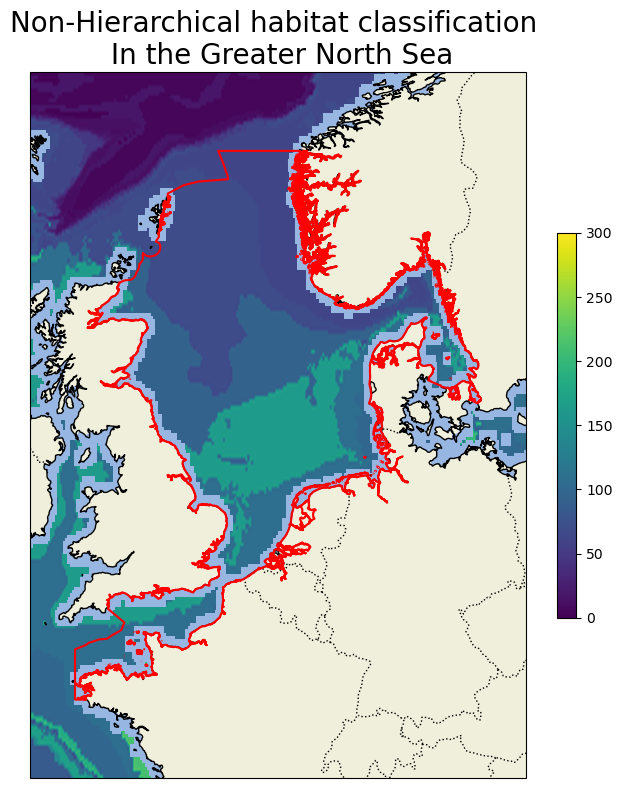

In [31]:
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs


fig = plt.figure(figsize=(8,10))# Increase the figure size
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

#add Basemap features from Cartopy
ax.add_feature(cartopy.feature.OCEAN, )
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.coastlines(resolution='10m')

#plot the data
cbar_kwargs = {'shrink':0.5, 'extend': 'neither'}                                                             
rasterdata.plot(ax = ax, cmap = 'viridis', vmin =0, vmax = 300, cbar_kwargs = cbar_kwargs) # plot raster data
Study_area.boundary.plot(ax=ax, color=None, edgecolor = 'red', label = 'Study Area')

ax.set_title('Non-Hierarchical habitat classification \n In the Greater North Sea', fontsize=20)


### [>> Next: Use OGC services from common GIS software](./4_OGC_services_from_common_GIS_software.ipynb)

<hr>

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img style="float: right" alt="Creative Commons Lizenzvertrag" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a>